In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (specific humidity) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (specific humidity) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (specific humidity) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (specific humidity) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 1
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)

#Since the NaN values of GHI are gone which is used in data preparation, simulate these in solar activity instead
df['solar_activity'].loc[df['Year'] > 2020] = np.nan
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when GHI is removed as a predictor
df_trimmed = df_trimmed.drop(['GHI'], axis=1)

n_vars = df_trimmed.shape[1]-1

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['specific_humidity'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 22
n_seq (number of output/future prediction time steps): 1
C:\Users\User
C:\Users\User\Modeling\
     file_id        date  specific_humidity          slp  vapor_pressure  \
0       6678  1998-12-31          12.816968  1016.202508       20.726068   
1       6678  1999-12-31          12.330412  1017.480181       19.960131   
2       6678  2000-12-31          12.136613  1018.259826       19.655271   
3       6678  2001-12-31          11.897962  1018.414173       19.285320   
4       6678  2002-12-31          12.751085  1017.916636       20.638060   
..       ...         ...                ...          ...             ...   
643     8000  2020-12-31           5.146134  1016.944161        8.168785   
644     8000  2021-12-31           5.239193  1016.159983        8.312383   
645     8000  2022-12-31           5.362553  1017.898453        8.512894   
646     8000  2023-12-31           5.430746  1016.166709        8.612808   
647     8000

C:\Users\User\AppData\Local\Temp\ipykernel_219416\4286122123.py:409: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['solar_activity'].loc[df['Year'] > 2020] = np.nan


     file_id  specific_humidity      slp  wet_bulb_temperature  temperatures  \
0       6678              12.82  1016.20                 18.08         20.84   
1       6678              12.33  1017.48                 17.71         20.69   
2       6678              12.14  1018.26                 17.29         20.47   
3       6678              11.90  1018.41                 17.20         20.30   
4       6678              12.75  1017.92                 17.75         20.46   
..       ...                ...      ...                   ...           ...   
643     8000               5.15  1016.94                  7.64         13.02   
644     8000               5.24  1016.16                  7.88         13.47   
645     8000               5.36  1017.90                  7.13         11.84   
646     8000               5.43  1016.17                  7.66         12.86   
647     8000               5.32  1015.12                  8.11         13.58   

     water      WDSP  PRCP  SNDP  regio

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

1
22
(19, 243)
(2, 243)


[I 2025-06-06 14:58:11,207] A new study created in memory with name: no-name-5c43537c-dfa4-4489-a772-1fdc0dfeba91
[I 2025-06-06 15:00:49,862] Trial 0 finished with value: 3.9514130115509034 and parameters: {'lr': 0.09466539281001739, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3989128287282785}. Best is trial 0 with value: 3.9514130115509034.


Cross Validation Accuracies:
[3.79968523979187, 4.005983829498291, 4.489642143249512, 3.5251073837280273, 3.9366464614868164]
Mean Cross Validation Accuracy:
3.9514130115509034
Standard Deviation of Cross Validation Accuracy:
0.3154819894756903


[I 2025-06-06 15:02:26,327] Trial 1 finished with value: 0.09954805076122283 and parameters: {'lr': 0.002406244280964401, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.1171402565406698}. Best is trial 1 with value: 0.09954805076122283.


Cross Validation Accuracies:
[0.10860206931829453, 0.1272769719362259, 0.07133888453245163, 0.1301993727684021, 0.06032295525074005]
Mean Cross Validation Accuracy:
0.09954805076122283
Standard Deviation of Cross Validation Accuracy:
0.028721897707073833


[I 2025-06-06 15:03:46,373] Trial 2 finished with value: 0.09737888351082802 and parameters: {'lr': 0.0011752619182290786, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.22947118757937068}. Best is trial 2 with value: 0.09737888351082802.


Cross Validation Accuracies:
[0.10252653062343597, 0.12896504998207092, 0.07194595783948898, 0.1298397332429886, 0.053617145866155624]
Mean Cross Validation Accuracy:
0.09737888351082802
Standard Deviation of Cross Validation Accuracy:
0.030462482953180006


[I 2025-06-06 15:05:39,032] Trial 3 finished with value: 0.4764614745974541 and parameters: {'lr': 0.8014020088139314, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.16802872348520284}. Best is trial 2 with value: 0.09737888351082802.


Cross Validation Accuracies:
[0.11786030232906342, 0.13311712443828583, 0.06353851407766342, 0.13026508688926697, 1.9375263452529907]
Mean Cross Validation Accuracy:
0.4764614745974541
Standard Deviation of Cross Validation Accuracy:
0.7309648432022968


[I 2025-06-06 15:07:19,775] Trial 4 finished with value: 17.6294885635376 and parameters: {'lr': 0.5769815429230947, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.25401779446586636}. Best is trial 2 with value: 0.09737888351082802.


Cross Validation Accuracies:
[36.37004089355469, 2.2548632621765137, 29.672775268554688, 3.7149786949157715, 16.134784698486328]
Mean Cross Validation Accuracy:
17.6294885635376
Standard Deviation of Cross Validation Accuracy:
13.62700175371513


[I 2025-06-06 15:10:27,762] Trial 5 finished with value: 0.25048659443855287 and parameters: {'lr': 0.00763535445762183, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4063883936243555}. Best is trial 2 with value: 0.09737888351082802.


Cross Validation Accuracies:
[0.351030170917511, 0.31945231556892395, 0.2619098126888275, 0.1538185179233551, 0.16622215509414673]
Mean Cross Validation Accuracy:
0.25048659443855287
Standard Deviation of Cross Validation Accuracy:
0.07929815146972954


[I 2025-06-06 15:11:56,866] Trial 6 finished with value: 0.22993351519107819 and parameters: {'lr': 0.0012911448532535671, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.49235371440833786}. Best is trial 2 with value: 0.09737888351082802.


Cross Validation Accuracies:
[0.1201920211315155, 0.3315110206604004, 0.2947123348712921, 0.11959309875965118, 0.28365910053253174]
Mean Cross Validation Accuracy:
0.22993351519107819
Standard Deviation of Cross Validation Accuracy:
0.09123478134297185


[I 2025-06-06 15:13:25,583] Trial 7 finished with value: 0.09462341256439685 and parameters: {'lr': 0.02066761858598938, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4143630717759338}. Best is trial 7 with value: 0.09462341256439685.


Cross Validation Accuracies:
[0.10910343378782272, 0.1272059679031372, 0.08145274966955185, 0.13561920821666718, 0.019735703244805336]
Mean Cross Validation Accuracy:
0.09462341256439685
Standard Deviation of Cross Validation Accuracy:
0.041793742489566375


[I 2025-06-06 15:14:53,390] Trial 8 finished with value: 0.08543370142579079 and parameters: {'lr': 0.15199209548098125, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.16764043193171654}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[0.05312778055667877, 0.12261205166578293, 0.05297895148396492, 0.08437581360340118, 0.11407390981912613]
Mean Cross Validation Accuracy:
0.08543370142579079
Standard Deviation of Cross Validation Accuracy:
0.029327781051466315


[I 2025-06-06 15:17:09,388] Trial 9 finished with value: 0.11189335882663727 and parameters: {'lr': 0.3834972867752127, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.13601275406974278}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[0.10458137840032578, 0.1299239993095398, 0.07159405946731567, 0.2013375610113144, 0.052029795944690704]
Mean Cross Validation Accuracy:
0.11189335882663727
Standard Deviation of Cross Validation Accuracy:
0.05212775469594837


[I 2025-06-06 15:18:55,090] Trial 10 finished with value: 0.0934547670185566 and parameters: {'lr': 0.10038876367573456, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.30718364582877405}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[0.0692826509475708, 0.12403186410665512, 0.05749085173010826, 0.19196270406246185, 0.02450576424598694]
Mean Cross Validation Accuracy:
0.0934547670185566
Standard Deviation of Cross Validation Accuracy:
0.058771475919082924


[I 2025-06-06 15:20:19,911] Trial 11 finished with value: 0.13349461704492568 and parameters: {'lr': 0.10789690697461073, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.32307131514751497}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[0.17699778079986572, 0.12364528328180313, 0.10670541226863861, 0.09008264541625977, 0.17004196345806122]
Mean Cross Validation Accuracy:
0.13349461704492568
Standard Deviation of Cross Validation Accuracy:
0.034431102030989896


[I 2025-06-06 15:21:37,398] Trial 12 finished with value: 0.0917810995131731 and parameters: {'lr': 0.13347361939254998, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2972760309938916}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[0.05970671772956848, 0.16812007129192352, 0.06344316899776459, 0.1606828272342682, 0.006952712312340736]
Mean Cross Validation Accuracy:
0.0917810995131731
Standard Deviation of Cross Validation Accuracy:
0.06261428949206349


[I 2025-06-06 15:23:05,673] Trial 13 finished with value: 0.08727558702230453 and parameters: {'lr': 0.20976762254000578, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.20258045758958587}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[0.03464306518435478, 0.12604665756225586, 0.06088627502322197, 0.07819405198097229, 0.13660788536071777]
Mean Cross Validation Accuracy:
0.08727558702230453
Standard Deviation of Cross Validation Accuracy:
0.0386934722961851


[I 2025-06-06 15:24:35,169] Trial 14 finished with value: 0.11541312858462334 and parameters: {'lr': 0.024349469086607747, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.19349255013071331}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[0.15906548500061035, 0.12715496122837067, 0.16176392138004303, 0.09673063457012177, 0.03235064074397087]
Mean Cross Validation Accuracy:
0.11541312858462334
Standard Deviation of Cross Validation Accuracy:
0.047833476386619625


[I 2025-06-06 15:26:07,535] Trial 15 finished with value: 0.09477956183254718 and parameters: {'lr': 0.24569332344510672, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.21597350241175378}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[0.028239334002137184, 0.13586056232452393, 0.08290444314479828, 0.073343425989151, 0.15355004370212555]
Mean Cross Validation Accuracy:
0.09477956183254718
Standard Deviation of Cross Validation Accuracy:
0.04509932687761927


[I 2025-06-06 15:27:45,601] Trial 16 finished with value: 0.4078250706195831 and parameters: {'lr': 0.04545738326084638, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.15501980674536786}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[0.18631772696971893, 0.7351963520050049, 0.28114157915115356, 0.10444347560405731, 0.732026219367981]
Mean Cross Validation Accuracy:
0.4078250706195831
Standard Deviation of Cross Validation Accuracy:
0.2718208760273313


[I 2025-06-06 15:29:09,702] Trial 17 finished with value: 0.09897842481732369 and parameters: {'lr': 0.2790387675404635, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.10456216028623413}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[0.030926760286092758, 0.1418175995349884, 0.08556502312421799, 0.07056109607219696, 0.16602164506912231]
Mean Cross Validation Accuracy:
0.09897842481732369
Standard Deviation of Cross Validation Accuracy:
0.04888451950399471


[I 2025-06-06 15:30:37,895] Trial 18 finished with value: 0.11319880355149507 and parameters: {'lr': 0.04902897052201991, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.26312151222195834}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[0.15840978920459747, 0.16332310438156128, 0.16363278031349182, 0.0690673291683197, 0.0115610146895051]
Mean Cross Validation Accuracy:
0.11319880355149507
Standard Deviation of Cross Validation Accuracy:
0.062254143517431755


[I 2025-06-06 15:33:07,341] Trial 19 finished with value: 0.1007147990167141 and parameters: {'lr': 0.011339279912488046, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.18466055980398768}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[0.09872788190841675, 0.14397025108337402, 0.08137211948633194, 0.12622004747390747, 0.0532836951315403]
Mean Cross Validation Accuracy:
0.1007147990167141
Standard Deviation of Cross Validation Accuracy:
0.03209158313056786


[I 2025-06-06 15:34:54,183] Trial 20 finished with value: 0.11533509008586407 and parameters: {'lr': 0.1966316273523455, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.34897899857848025}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[0.15295664966106415, 0.16696055233478546, 0.1298501193523407, 0.123992919921875, 0.0029152091592550278]
Mean Cross Validation Accuracy:
0.11533509008586407
Standard Deviation of Cross Validation Accuracy:
0.058317139533612394


[I 2025-06-06 15:36:45,804] Trial 21 finished with value: 0.08767706230282783 and parameters: {'lr': 0.15150171634550683, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2811889434138031}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[0.05667382478713989, 0.12275613099336624, 0.05472452566027641, 0.09402602165937424, 0.11020480841398239]
Mean Cross Validation Accuracy:
0.08767706230282783
Standard Deviation of Cross Validation Accuracy:
0.027660152196212096


[I 2025-06-06 15:38:31,854] Trial 22 finished with value: 12.87603385746479 and parameters: {'lr': 0.5044722764947049, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2570176219332016}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[34.4080924987793, 2.2218356132507324, 27.291866302490234, 0.15601898729801178, 0.30235588550567627]
Mean Cross Validation Accuracy:
12.87603385746479
Standard Deviation of Cross Validation Accuracy:
14.865085742657946


[I 2025-06-06 15:40:24,058] Trial 23 finished with value: 0.10537801198661327 and parameters: {'lr': 0.05688905818452455, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.22213690228030092}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[0.18764063715934753, 0.12176770716905594, 0.05417266860604286, 0.13290295004844666, 0.030406096950173378]
Mean Cross Validation Accuracy:
0.10537801198661327
Standard Deviation of Cross Validation Accuracy:
0.05663242721046699


[I 2025-06-06 15:42:13,423] Trial 24 finished with value: 29.177880382537843 and parameters: {'lr': 0.9621376627084837, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2749574770155087}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[24.80746841430664, 40.624534606933594, 54.20735549926758, 3.981492519378662, 22.268550872802734]
Mean Cross Validation Accuracy:
29.177880382537843
Standard Deviation of Cross Validation Accuracy:
17.083312406841834


[I 2025-06-06 15:44:08,230] Trial 25 finished with value: 0.12181770205497741 and parameters: {'lr': 0.1777996489201028, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.35618123124055967}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[0.17963510751724243, 0.17630282044410706, 0.056351013481616974, 0.07405775785446167, 0.12274181097745895]
Mean Cross Validation Accuracy:
0.12181770205497741
Standard Deviation of Cross Validation Accuracy:
0.05075280102686703


[I 2025-06-06 15:45:50,068] Trial 26 finished with value: 0.11550063341856003 and parameters: {'lr': 0.06758298791808656, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.20781904195720968}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[0.1751999408006668, 0.12711763381958008, 0.1137598529458046, 0.09017953276634216, 0.0712462067604065]
Mean Cross Validation Accuracy:
0.11550063341856003
Standard Deviation of Cross Validation Accuracy:
0.035500999236518775


[I 2025-06-06 15:47:27,987] Trial 27 finished with value: 0.1388258770108223 and parameters: {'lr': 0.36151850155864185, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.16429509400980774}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[0.07817327976226807, 0.1789788454771042, 0.13883769512176514, 0.07711384445428848, 0.2210257202386856]
Mean Cross Validation Accuracy:
0.1388258770108223
Standard Deviation of Cross Validation Accuracy:
0.05631374212083814


[I 2025-06-06 15:48:53,965] Trial 28 finished with value: 0.16089009419083594 and parameters: {'lr': 0.03210896307277198, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.14004908625080112}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[0.11907679587602615, 0.12510673701763153, 0.052524980157613754, 0.1299736201763153, 0.377768337726593]
Mean Cross Validation Accuracy:
0.16089009419083594
Standard Deviation of Cross Validation Accuracy:
0.11203909977380873


[I 2025-06-06 15:51:07,390] Trial 29 finished with value: 2.3213824033737183 and parameters: {'lr': 0.15287111369892245, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.23757270991982837}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[2.503516912460327, 1.5260013341903687, 1.8032060861587524, 4.237928867340088, 1.5362588167190552]
Mean Cross Validation Accuracy:
2.3213824033737183
Standard Deviation of Cross Validation Accuracy:
1.0221428584304064


[I 2025-06-06 15:54:10,031] Trial 30 finished with value: 3.4811083316802978 and parameters: {'lr': 0.0781765293905369, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.349327904292816}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[3.625424385070801, 3.4432008266448975, 3.1656553745269775, 3.1685678958892822, 4.002693176269531]
Mean Cross Validation Accuracy:
3.4811083316802978
Standard Deviation of Cross Validation Accuracy:
0.3135305230725094


[I 2025-06-06 15:55:57,664] Trial 31 finished with value: 0.09232510328292846 and parameters: {'lr': 0.12179651346083545, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.28505431533237835}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[0.16441193222999573, 0.12377647310495377, 0.05233025178313255, 0.09181786328554153, 0.029288996011018753]
Mean Cross Validation Accuracy:
0.09232510328292846
Standard Deviation of Cross Validation Accuracy:
0.048495558209442076


[I 2025-06-06 15:57:29,690] Trial 32 finished with value: 0.14750007316470146 and parameters: {'lr': 0.2684668323378163, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.309823543872832}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[0.03683975711464882, 0.14445935189723969, 0.10997483879327774, 0.26440712809562683, 0.18181928992271423]
Mean Cross Validation Accuracy:
0.14750007316470146
Standard Deviation of Cross Validation Accuracy:
0.075509155577665


[I 2025-06-06 15:58:53,874] Trial 33 finished with value: 0.10520238503813743 and parameters: {'lr': 0.15241613871357237, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.1892677599166257}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[0.0691666528582573, 0.12097439169883728, 0.052476685494184494, 0.17551013827323914, 0.10788405686616898]
Mean Cross Validation Accuracy:
0.10520238503813743
Standard Deviation of Cross Validation Accuracy:
0.043075981959801266


[I 2025-06-06 16:00:25,039] Trial 34 finished with value: 0.14842857867479325 and parameters: {'lr': 0.08377948315317188, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.38294741155544076}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[0.11017081886529922, 0.16704192757606506, 0.13767361640930176, 0.22523392736911774, 0.10202260315418243]
Mean Cross Validation Accuracy:
0.14842857867479325
Standard Deviation of Cross Validation Accuracy:
0.0446729410457155


[I 2025-06-06 16:01:56,180] Trial 35 finished with value: 14.698907852172852 and parameters: {'lr': 0.6474392083621715, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.24467415805484571}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[25.531579971313477, 11.134510040283203, 5.3665971755981445, 13.875554084777832, 17.5862979888916]
Mean Cross Validation Accuracy:
14.698907852172852
Standard Deviation of Cross Validation Accuracy:
6.725454226953373


[I 2025-06-06 16:03:11,912] Trial 36 finished with value: 0.1688373178243637 and parameters: {'lr': 0.3867829977333269, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1284696311872035}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[0.10925693064928055, 0.2053220421075821, 0.16574741899967194, 0.10555518418550491, 0.25830501317977905]
Mean Cross Validation Accuracy:
0.1688373178243637
Standard Deviation of Cross Validation Accuracy:
0.05813708294504962


[I 2025-06-06 16:04:59,071] Trial 37 finished with value: 0.27199843525886536 and parameters: {'lr': 0.004949038233224915, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.32803330066789144}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[0.21043819189071655, 0.29772406816482544, 0.35973042249679565, 0.22320258617401123, 0.2688969075679779]
Mean Cross Validation Accuracy:
0.27199843525886536
Standard Deviation of Cross Validation Accuracy:
0.05392407198757062


[I 2025-06-06 16:06:29,424] Trial 38 finished with value: 0.13467221558094025 and parameters: {'lr': 0.19629230522550736, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.44758535500893076}. Best is trial 8 with value: 0.08543370142579079.


Cross Validation Accuracies:
[0.05397607386112213, 0.1625962257385254, 0.1126781776547432, 0.2535611689090729, 0.09054943174123764]
Mean Cross Validation Accuracy:
0.13467221558094025
Standard Deviation of Cross Validation Accuracy:
0.06907497175282651


[I 2025-06-06 16:07:59,313] Trial 39 finished with value: 0.06815262483432889 and parameters: {'lr': 0.014778545662628663, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.17291248840804552}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.08587878197431564, 0.127869114279747, 0.05584335699677467, 0.06696021556854248, 0.004211655352264643]
Mean Cross Validation Accuracy:
0.06815262483432889
Standard Deviation of Cross Validation Accuracy:
0.04030301043717774


[I 2025-06-06 16:09:24,687] Trial 40 finished with value: 0.10635334998369217 and parameters: {'lr': 0.013857654019716647, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.17219395727382852}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.10231650620698929, 0.12237037718296051, 0.16436715424060822, 0.12447065114974976, 0.018242061138153076]
Mean Cross Validation Accuracy:
0.10635334998369217
Standard Deviation of Cross Validation Accuracy:
0.048436099297740794


[I 2025-06-06 16:10:47,445] Trial 41 finished with value: 0.13115872591733932 and parameters: {'lr': 0.00569210031858418, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2884983468818816}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.09719685465097427, 0.1223195269703865, 0.0943043902516365, 0.2146667093038559, 0.12730614840984344]
Mean Cross Validation Accuracy:
0.13115872591733932
Standard Deviation of Cross Validation Accuracy:
0.043768042766455184


[I 2025-06-06 16:12:21,140] Trial 42 finished with value: 0.08690501302480698 and parameters: {'lr': 0.03544413163167452, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1549527089515514}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.09856673330068588, 0.13710609078407288, 0.06166765093803406, 0.08477955311536789, 0.052405036985874176]
Mean Cross Validation Accuracy:
0.08690501302480698
Standard Deviation of Cross Validation Accuracy:
0.029959420220014802


[I 2025-06-06 16:13:37,200] Trial 43 finished with value: 0.07399385794997215 and parameters: {'lr': 0.002503345765810467, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.14801004929222786}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.04997687786817551, 0.1318737119436264, 0.06885926425457001, 0.10723553597927094, 0.01202389970421791]
Mean Cross Validation Accuracy:
0.07399385794997215
Standard Deviation of Cross Validation Accuracy:
0.042186589732229135


[I 2025-06-06 16:14:58,791] Trial 44 finished with value: 0.07607724443078041 and parameters: {'lr': 0.0022271135060469047, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.11261408157407124}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.052149415016174316, 0.12093184888362885, 0.05230966955423355, 0.12458693236112595, 0.030408356338739395]
Mean Cross Validation Accuracy:
0.07607724443078041
Standard Deviation of Cross Validation Accuracy:
0.03895692836785549


[I 2025-06-06 16:16:17,862] Trial 45 finished with value: 0.12750859558582306 and parameters: {'lr': 0.002218635053668079, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.10129522638761845}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.07355102151632309, 0.12499208748340607, 0.09125880151987076, 0.26199617981910706, 0.08574488759040833]
Mean Cross Validation Accuracy:
0.12750859558582306
Standard Deviation of Cross Validation Accuracy:
0.06937278688469994


[I 2025-06-06 16:17:36,381] Trial 46 finished with value: 0.08846246674656869 and parameters: {'lr': 0.002738019685512243, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1473698365140935}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.06227107718586922, 0.1251768171787262, 0.07098941504955292, 0.0986526757478714, 0.08522234857082367]
Mean Cross Validation Accuracy:
0.08846246674656869
Standard Deviation of Cross Validation Accuracy:
0.02215210453056409


[I 2025-06-06 16:18:48,421] Trial 47 finished with value: 0.11748533546924592 and parameters: {'lr': 0.001521836733717712, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.11839710741234577}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.09159906208515167, 0.12866289913654327, 0.10331426560878754, 0.21128372848033905, 0.05256672203540802]
Mean Cross Validation Accuracy:
0.11748533546924592
Standard Deviation of Cross Validation Accuracy:
0.05293093840444945


[I 2025-06-06 16:20:13,163] Trial 48 finished with value: 0.10299524664878845 and parameters: {'lr': 0.00353265982982976, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.12543837573117955}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.13158561289310455, 0.13708379864692688, 0.05233677104115486, 0.14578281342983246, 0.04818723723292351]
Mean Cross Validation Accuracy:
0.10299524664878845
Standard Deviation of Cross Validation Accuracy:
0.04331376995223336


[I 2025-06-06 16:21:34,842] Trial 49 finished with value: 0.07630351483821869 and parameters: {'lr': 0.009592434226292908, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.17414820722835717}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.03854101151227951, 0.12177608907222748, 0.05368165671825409, 0.08086122572422028, 0.08665759116411209]
Mean Cross Validation Accuracy:
0.07630351483821869
Standard Deviation of Cross Validation Accuracy:
0.02875235557234092


[I 2025-06-06 16:23:06,224] Trial 50 finished with value: 0.10921372957527638 and parameters: {'lr': 0.009723057601022536, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1786364271866659}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.16892559826374054, 0.18196795880794525, 0.09865757077932358, 0.07687100023031235, 0.019646519795060158]
Mean Cross Validation Accuracy:
0.10921372957527638
Standard Deviation of Cross Validation Accuracy:
0.060064057191182726


[I 2025-06-06 16:24:29,515] Trial 51 finished with value: 0.1252232164144516 and parameters: {'lr': 0.018200901979202287, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.15697330505822144}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.06762711703777313, 0.12868794798851013, 0.07898904383182526, 0.280224472284317, 0.07058750092983246]
Mean Cross Validation Accuracy:
0.1252232164144516
Standard Deviation of Cross Validation Accuracy:
0.08059449667370636


[I 2025-06-06 16:25:52,619] Trial 52 finished with value: 0.11171482503414154 and parameters: {'lr': 0.0325913516155522, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.14188842354984257}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.1487102061510086, 0.17009560763835907, 0.0674050822854042, 0.10601552575826645, 0.06634770333766937]
Mean Cross Validation Accuracy:
0.11171482503414154
Standard Deviation of Cross Validation Accuracy:
0.04202614673552868


[I 2025-06-06 16:27:10,054] Trial 53 finished with value: 0.09874360077083111 and parameters: {'lr': 0.001791678758184511, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.11184653772703557}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.08432579040527344, 0.13609446585178375, 0.14064224064350128, 0.12042905390262604, 0.012226453050971031]
Mean Cross Validation Accuracy:
0.09874360077083111
Standard Deviation of Cross Validation Accuracy:
0.04756875472055955


[I 2025-06-06 16:28:31,302] Trial 54 finished with value: 0.0989170778542757 and parameters: {'lr': 0.001027315164894269, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.16642459687339342}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.11485431343317032, 0.13247841596603394, 0.06499885022640228, 0.17076385021209717, 0.011489959433674812]
Mean Cross Validation Accuracy:
0.0989170778542757
Standard Deviation of Cross Validation Accuracy:
0.05538278576007452


[I 2025-06-06 16:29:57,580] Trial 55 finished with value: 0.10137724205851555 and parameters: {'lr': 0.006942863117705363, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.19930400550990834}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.060266654938459396, 0.1461307257413864, 0.06538048386573792, 0.15797008574008942, 0.0771382600069046]
Mean Cross Validation Accuracy:
0.10137724205851555
Standard Deviation of Cross Validation Accuracy:
0.041902266006418776


[I 2025-06-06 16:31:12,510] Trial 56 finished with value: 0.09830921590328216 and parameters: {'lr': 0.003584578543513109, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.15169850196379445}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.11847174912691116, 0.14426849782466888, 0.06503879278898239, 0.06775687634944916, 0.09601016342639923]
Mean Cross Validation Accuracy:
0.09830921590328216
Standard Deviation of Cross Validation Accuracy:
0.03021402154441593


[I 2025-06-06 16:32:45,442] Trial 57 finished with value: 0.0910156775265932 and parameters: {'lr': 0.016550492681123765, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.12984043581172758}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.15482395887374878, 0.137526273727417, 0.05230008065700531, 0.1079120859503746, 0.0025159884244203568]
Mean Cross Validation Accuracy:
0.0910156775265932
Standard Deviation of Cross Validation Accuracy:
0.05630508566232144


[I 2025-06-06 16:34:17,133] Trial 58 finished with value: 0.09450691267848015 and parameters: {'lr': 0.026409794696520137, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.21207573620854264}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.11402930319309235, 0.12091697007417679, 0.08090853691101074, 0.10822650045156479, 0.048453252762556076]
Mean Cross Validation Accuracy:
0.09450691267848015
Standard Deviation of Cross Validation Accuracy:
0.02673087116753689


[I 2025-06-06 16:35:44,916] Trial 59 finished with value: 0.10898724496364594 and parameters: {'lr': 0.009785468515007532, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1818075124721956}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.13699790835380554, 0.12345565855503082, 0.05703563243150711, 0.12855158746242523, 0.09889543801546097]
Mean Cross Validation Accuracy:
0.10898724496364594
Standard Deviation of Cross Validation Accuracy:
0.028905052724347895


[I 2025-06-06 16:37:17,441] Trial 60 finished with value: 0.08944483622908592 and parameters: {'lr': 0.0038908482182977377, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.11382077309158437}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.1119566261768341, 0.14366839826107025, 0.05348456650972366, 0.09623851627111435, 0.04187607392668724]
Mean Cross Validation Accuracy:
0.08944483622908592
Standard Deviation of Cross Validation Accuracy:
0.037547456904224105


[I 2025-06-06 16:39:26,862] Trial 61 finished with value: 0.10044158026576042 and parameters: {'lr': 0.0027366075112356817, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.22681666513074042}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.06806674599647522, 0.12114976346492767, 0.060951050370931625, 0.13941533863544464, 0.11262500286102295]
Mean Cross Validation Accuracy:
0.10044158026576042
Standard Deviation of Cross Validation Accuracy:
0.03067197523584553


[I 2025-06-06 16:41:08,492] Trial 62 finished with value: 0.0884089956060052 and parameters: {'lr': 0.0411319308661977, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1999019144209566}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.10702710598707199, 0.12931109964847565, 0.07685182243585587, 0.1187606081366539, 0.010094341821968555]
Mean Cross Validation Accuracy:
0.0884089956060052
Standard Deviation of Cross Validation Accuracy:
0.042912911300613574


[I 2025-06-06 16:42:56,162] Trial 63 finished with value: 0.09978260099887848 and parameters: {'lr': 0.006799077013731151, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.16641021080647914}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.09125588834285736, 0.14251935482025146, 0.07248346507549286, 0.11729930341243744, 0.07535499334335327]
Mean Cross Validation Accuracy:
0.09978260099887848
Standard Deviation of Cross Validation Accuracy:
0.026638020411764565


[I 2025-06-06 16:44:15,476] Trial 64 finished with value: 0.07384018329903483 and parameters: {'lr': 0.0018217409022807075, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.14121847579137634}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.041767917573451996, 0.1209382638335228, 0.0591743029654026, 0.14110350608825684, 0.006216926034539938]
Mean Cross Validation Accuracy:
0.07384018329903483
Standard Deviation of Cross Validation Accuracy:
0.050118274073381784


[I 2025-06-06 16:45:37,542] Trial 65 finished with value: 0.12110605835914612 and parameters: {'lr': 0.001898923169940885, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.13934331065799357}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.09868410229682922, 0.12778939306735992, 0.11813731491565704, 0.13141050934791565, 0.12950897216796875]
Mean Cross Validation Accuracy:
0.12110605835914612
Standard Deviation of Cross Validation Accuracy:
0.012107974106135174


[I 2025-06-06 16:47:06,557] Trial 66 finished with value: 0.07721148580312728 and parameters: {'lr': 0.0012222066569245326, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1559066444253438}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.09159524738788605, 0.12590652704238892, 0.06213070824742317, 0.09563156962394714, 0.010793376713991165]
Mean Cross Validation Accuracy:
0.07721148580312728
Standard Deviation of Cross Validation Accuracy:
0.038874655479496194


[I 2025-06-06 16:48:30,089] Trial 67 finished with value: 0.09034332633018494 and parameters: {'lr': 0.001333855631156542, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.12251754659301678}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.10609634220600128, 0.1308007389307022, 0.05233554542064667, 0.08561331778764725, 0.07687068730592728]
Mean Cross Validation Accuracy:
0.09034332633018494
Standard Deviation of Cross Validation Accuracy:
0.02658358943510115


[I 2025-06-06 16:50:29,168] Trial 68 finished with value: 0.0945796325802803 and parameters: {'lr': 0.0010040295664907664, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1871833823684685}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.1070576161146164, 0.1218741238117218, 0.1174674853682518, 0.06568768620491028, 0.060811251401901245]
Mean Cross Validation Accuracy:
0.0945796325802803
Standard Deviation of Cross Validation Accuracy:
0.026075242137613284


[I 2025-06-06 16:51:58,532] Trial 69 finished with value: 0.10025204569101334 and parameters: {'lr': 0.0013301649772081146, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.13614366461747798}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.09455890953540802, 0.13300757110118866, 0.06878288090229034, 0.11861150711774826, 0.0862993597984314]
Mean Cross Validation Accuracy:
0.10025204569101334
Standard Deviation of Cross Validation Accuracy:
0.02292331496175685


[I 2025-06-06 16:53:43,716] Trial 70 finished with value: 0.09946650564670563 and parameters: {'lr': 0.002157891697262962, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.10262869730443819}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.07505033165216446, 0.12166236340999603, 0.11970070749521255, 0.16052018105983734, 0.02039894461631775]
Mean Cross Validation Accuracy:
0.09946650564670563
Standard Deviation of Cross Validation Accuracy:
0.04791129108586452


[I 2025-06-06 16:55:17,838] Trial 71 finished with value: 0.09402985572814941 and parameters: {'lr': 0.0015981557442247406, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.15171384730141105}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.0884871780872345, 0.12707369029521942, 0.06393704563379288, 0.13829918205738068, 0.0523521825671196]
Mean Cross Validation Accuracy:
0.09402985572814941
Standard Deviation of Cross Validation Accuracy:
0.03383783442084788


[I 2025-06-06 16:56:42,924] Trial 72 finished with value: 0.07837285473942757 and parameters: {'lr': 0.002847349204113727, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1599281455902503}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.1004854366183281, 0.12144609540700912, 0.05873884633183479, 0.08924929052591324, 0.021944604814052582]
Mean Cross Validation Accuracy:
0.07837285473942757
Standard Deviation of Cross Validation Accuracy:
0.03473387070329489


[I 2025-06-06 16:58:27,464] Trial 73 finished with value: 0.13275998830795288 and parameters: {'lr': 0.0026031471325139175, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.17414557022199847}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.1598951816558838, 0.12591645121574402, 0.07995939254760742, 0.23095090687274933, 0.06707800924777985]
Mean Cross Validation Accuracy:
0.13275998830795288
Standard Deviation of Cross Validation Accuracy:
0.0592058012233074


[I 2025-06-06 17:00:07,338] Trial 74 finished with value: 0.1038098655641079 and parameters: {'lr': 0.005022317768597295, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.16163799800190895}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.046704355627298355, 0.12094978243112564, 0.10768255591392517, 0.15391018986701965, 0.08980244398117065]
Mean Cross Validation Accuracy:
0.1038098655641079
Standard Deviation of Cross Validation Accuracy:
0.03542898276991866


[I 2025-06-06 17:01:33,146] Trial 75 finished with value: 0.11034970134496688 and parameters: {'lr': 0.003364990763931971, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.19074366838982865}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.09241241216659546, 0.1212511956691742, 0.06685669720172882, 0.19304685294628143, 0.07818134874105453]
Mean Cross Validation Accuracy:
0.11034970134496688
Standard Deviation of Cross Validation Accuracy:
0.04517931412315465


[I 2025-06-06 17:03:01,681] Trial 76 finished with value: 0.09321977570652962 and parameters: {'lr': 0.004100489658208907, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.12965287131266343}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.09731987118721008, 0.1312965601682663, 0.06472557783126831, 0.12894108891487122, 0.04381578043103218]
Mean Cross Validation Accuracy:
0.09321977570652962
Standard Deviation of Cross Validation Accuracy:
0.03462755716755257


[I 2025-06-06 17:04:24,778] Trial 77 finished with value: 0.10849238187074661 and parameters: {'lr': 0.0020749575296956186, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.17661930146985874}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.1098141074180603, 0.12355329841375351, 0.056298285722732544, 0.15614749491214752, 0.09664872288703918]
Mean Cross Validation Accuracy:
0.10849238187074661
Standard Deviation of Cross Validation Accuracy:
0.03275388189316506


[I 2025-06-06 17:06:34,549] Trial 78 finished with value: 0.08812475427985192 and parameters: {'lr': 0.0029633449547483777, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.147773745633696}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.12533994019031525, 0.13889560103416443, 0.0579952746629715, 0.0649656429886818, 0.0534273125231266]
Mean Cross Validation Accuracy:
0.08812475427985192
Standard Deviation of Cross Validation Accuracy:
0.03636121940953684


[I 2025-06-06 17:07:57,062] Trial 79 finished with value: 0.12913671731948853 and parameters: {'lr': 0.01275460141319361, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.21561679020849361}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.1221928596496582, 0.12681104242801666, 0.11651875078678131, 0.16689911484718323, 0.11326181888580322]
Mean Cross Validation Accuracy:
0.12913671731948853
Standard Deviation of Cross Validation Accuracy:
0.019446593890857445


[I 2025-06-06 17:09:22,906] Trial 80 finished with value: 0.08091518506407738 and parameters: {'lr': 0.0016948857477189815, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1142472766524078}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.08019354939460754, 0.14237496256828308, 0.059801455587148666, 0.07292556017637253, 0.04928039759397507]
Mean Cross Validation Accuracy:
0.08091518506407738
Standard Deviation of Cross Validation Accuracy:
0.032521403615021365


[I 2025-06-06 17:10:52,532] Trial 81 finished with value: 0.08560173641890287 and parameters: {'lr': 0.0016971626265586107, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.11236504319528956}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.03788787126541138, 0.12859301269054413, 0.06528621912002563, 0.1822616308927536, 0.013979948125779629]
Mean Cross Validation Accuracy:
0.08560173641890287
Standard Deviation of Cross Validation Accuracy:
0.06166100674570933


[I 2025-06-06 17:12:13,084] Trial 82 finished with value: 0.11353320926427841 and parameters: {'lr': 0.001430124489258849, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1327340133555008}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.17600615322589874, 0.13386261463165283, 0.05730658769607544, 0.070979543030262, 0.12951114773750305]
Mean Cross Validation Accuracy:
0.11353320926427841
Standard Deviation of Cross Validation Accuracy:
0.04368911866954268


[I 2025-06-06 17:13:46,277] Trial 83 finished with value: 0.12800477147102357 and parameters: {'lr': 0.0011709536347114097, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4988345267296318}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.16118726134300232, 0.13010965287685394, 0.059739746153354645, 0.23371168971061707, 0.055275507271289825]
Mean Cross Validation Accuracy:
0.12800477147102357
Standard Deviation of Cross Validation Accuracy:
0.06667701294480032


[I 2025-06-06 17:15:24,382] Trial 84 finished with value: 0.17637589573860168 and parameters: {'lr': 0.002413272429457697, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.14230824502571204}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.30858027935028076, 0.13078418374061584, 0.0835486501455307, 0.2179444432258606, 0.14102192223072052]
Mean Cross Validation Accuracy:
0.17637589573860168
Standard Deviation of Cross Validation Accuracy:
0.07893205731063148


[I 2025-06-06 17:17:10,886] Trial 85 finished with value: 0.08991609364748002 and parameters: {'lr': 0.0011781521049480813, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.16094273878360416}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.032040759921073914, 0.1282154619693756, 0.05478249490261078, 0.0694757029414177, 0.16506604850292206]
Mean Cross Validation Accuracy:
0.08991609364748002
Standard Deviation of Cross Validation Accuracy:
0.049226194075016674


[I 2025-06-06 17:18:52,665] Trial 86 finished with value: 0.09241171181201935 and parameters: {'lr': 0.004920868544477821, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.11797783057509549}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.08431240171194077, 0.14763009548187256, 0.06732053309679031, 0.12320008128881454, 0.03959544748067856]
Mean Cross Validation Accuracy:
0.09241171181201935
Standard Deviation of Cross Validation Accuracy:
0.03868259929602876


[I 2025-06-06 17:20:38,643] Trial 87 finished with value: 0.09952394515275956 and parameters: {'lr': 0.0030528590980797394, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.10945236181013944}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.10580513626337051, 0.1220298483967781, 0.07019422948360443, 0.1280130296945572, 0.07157748192548752]
Mean Cross Validation Accuracy:
0.09952394515275956
Standard Deviation of Cross Validation Accuracy:
0.024490136825969705


[I 2025-06-06 17:22:21,493] Trial 88 finished with value: 0.10021560937166214 and parameters: {'lr': 0.02527613558769482, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1689065310188611}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.06946928054094315, 0.12142734229564667, 0.060998208820819855, 0.20273065567016602, 0.046452559530735016]
Mean Cross Validation Accuracy:
0.10021560937166214
Standard Deviation of Cross Validation Accuracy:
0.05715431585095348


[I 2025-06-06 17:24:05,904] Trial 89 finished with value: 0.10207191705703736 and parameters: {'lr': 0.0019085719821460598, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.14727127024580447}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.07659009099006653, 0.12232755869626999, 0.0849098265171051, 0.11490418761968613, 0.11162792146205902]
Mean Cross Validation Accuracy:
0.10207191705703736
Standard Deviation of Cross Validation Accuracy:
0.01794511753991607


[I 2025-06-06 17:26:29,955] Trial 90 finished with value: 0.09085818193852901 and parameters: {'lr': 0.004363759892770083, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.10089071232046884}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.12257593870162964, 0.1222643256187439, 0.08312934637069702, 0.1081090047955513, 0.018212294206023216]
Mean Cross Validation Accuracy:
0.09085818193852901
Standard Deviation of Cross Validation Accuracy:
0.03905665819772168


[I 2025-06-06 17:28:13,418] Trial 91 finished with value: 0.08579014278948308 and parameters: {'lr': 0.0016238187791655669, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.11549070627060984}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.03039960004389286, 0.16785554587841034, 0.09872952848672867, 0.06787165254354477, 0.06409438699483871]
Mean Cross Validation Accuracy:
0.08579014278948308
Standard Deviation of Cross Validation Accuracy:
0.04639406950077969


[I 2025-06-06 17:29:39,190] Trial 92 finished with value: 0.10255979895591735 and parameters: {'lr': 0.0017308008513624627, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.12340109511377059}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.12342370301485062, 0.14250540733337402, 0.09778445214033127, 0.09126687794923782, 0.05781855434179306]
Mean Cross Validation Accuracy:
0.10255979895591735
Standard Deviation of Cross Validation Accuracy:
0.028924270407111905


[I 2025-06-06 17:31:02,183] Trial 93 finished with value: 0.15016112923622132 and parameters: {'lr': 0.0022429468518745587, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1333606469936299}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.13266059756278992, 0.16650617122650146, 0.15998616814613342, 0.1712808758020401, 0.12037183344364166]
Mean Cross Validation Accuracy:
0.15016112923622132
Standard Deviation of Cross Validation Accuracy:
0.020017023929247337


[I 2025-06-06 17:32:26,925] Trial 94 finished with value: 0.08207529000937938 and parameters: {'lr': 0.008447351089923475, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4634849722830806}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.12267502397298813, 0.12475360184907913, 0.061640456318855286, 0.07949499040842056, 0.021812377497553825]
Mean Cross Validation Accuracy:
0.08207529000937938
Standard Deviation of Cross Validation Accuracy:
0.03879596808381121


[I 2025-06-06 17:34:06,074] Trial 95 finished with value: 0.17858162820339202 and parameters: {'lr': 0.00947996489994295, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4615405267919356}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.22951549291610718, 0.1863718032836914, 0.08834514021873474, 0.2379789650440216, 0.1506967395544052]
Mean Cross Validation Accuracy:
0.17858162820339202
Standard Deviation of Cross Validation Accuracy:
0.0549603125989758


[I 2025-06-06 17:35:53,451] Trial 96 finished with value: 0.12840835452079774 and parameters: {'lr': 0.005934222444905406, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4451058459071823}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.06914463639259338, 0.12091586738824844, 0.07883922010660172, 0.2928251028060913, 0.0803169459104538]
Mean Cross Validation Accuracy:
0.12840835452079774
Standard Deviation of Cross Validation Accuracy:
0.08410835325366911


[I 2025-06-06 17:37:20,558] Trial 97 finished with value: 0.23038147538900375 and parameters: {'lr': 0.02052436682694406, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.38035615334672607}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.03857990354299545, 0.31792619824409485, 0.19752240180969238, 0.49338260293006897, 0.10449627041816711]
Mean Cross Validation Accuracy:
0.23038147538900375
Standard Deviation of Cross Validation Accuracy:
0.1615848495975325


[I 2025-06-06 17:38:50,115] Trial 98 finished with value: 0.10914894863963127 and parameters: {'lr': 0.007683150651546114, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4196392458474168}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.12771202623844147, 0.1399639993906021, 0.10487106442451477, 0.14971107244491577, 0.023486580699682236]
Mean Cross Validation Accuracy:
0.10914894863963127
Standard Deviation of Cross Validation Accuracy:
0.04537793002056558


[I 2025-06-06 17:40:17,420] Trial 99 finished with value: 0.14587479159235955 and parameters: {'lr': 0.011353139606859457, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4775965451387248}. Best is trial 39 with value: 0.06815262483432889.


Cross Validation Accuracies:
[0.09425297379493713, 0.14469164609909058, 0.05495583638548851, 0.23479339480400085, 0.20068010687828064]
Mean Cross Validation Accuracy:
0.14587479159235955
Standard Deviation of Cross Validation Accuracy:
0.0660947938987271
Number of finished trials: 100
Best trial: {'lr': 0.014778545662628663, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.17291248840804552}
Best hyperparameters:  {'lr': 0.014778545662628663, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.17291248840804552}
Fold 1:
Epoch 1/100
19/19 [==============================] - 10s 183ms/step - loss: 0.3723 - val_loss: 0.0788
Epoch 2/100
19/19 [==============================] - 0s 21ms/step - loss: 0.0844 - val_loss: 0.1986
Epoch 3/100
19/19 [==============================] - 0s 21ms/step - loss: 0.1478 - val_loss: 0.0636
Epoch 4/100
19/19 [==============================] - 0s 21ms/step - loss: 0.1154 - val_loss: 0.

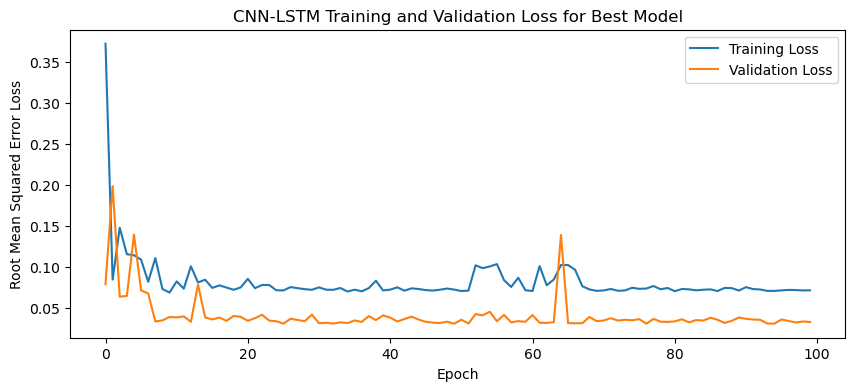

1/1 - 3s - loss: 0.1138 - 3s/epoch - 3s/step
Test Loss: 0.11377669870853424
Fold 2:
Epoch 1/100
19/19 [==============================] - 11s 155ms/step - loss: 0.4383 - val_loss: 0.2801
Epoch 2/100
19/19 [==============================] - 0s 17ms/step - loss: 0.2027 - val_loss: 0.1540
Epoch 3/100
19/19 [==============================] - 0s 12ms/step - loss: 0.0814 - val_loss: 0.0661
Epoch 4/100
19/19 [==============================] - 0s 12ms/step - loss: 0.0760 - val_loss: 0.0730
Epoch 5/100
19/19 [==============================] - 0s 9ms/step - loss: 0.0899 - val_loss: 0.1212
Epoch 6/100
19/19 [==============================] - 0s 9ms/step - loss: 0.0925 - val_loss: 0.1378
Epoch 7/100
19/19 [==============================] - 0s 9ms/step - loss: 0.0949 - val_loss: 0.0444
Epoch 8/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0785 - val_loss: 0.0463
Epoch 9/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0887 - val_loss: 0.0671
Epoch 10/100
19/19 

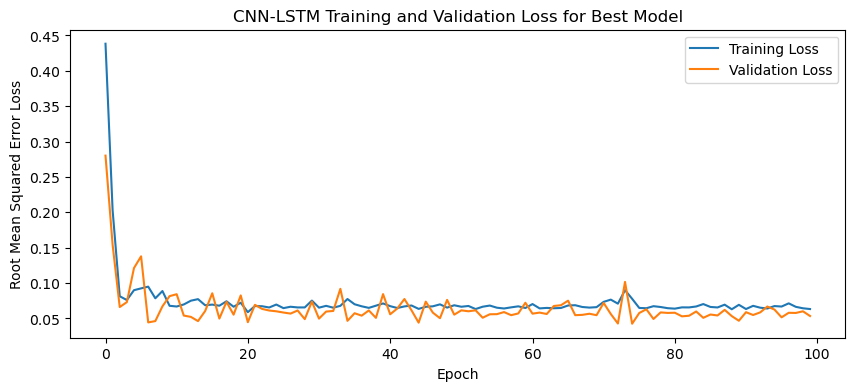

1/1 - 2s - loss: 0.1363 - 2s/epoch - 2s/step
Test Loss: 0.13634942471981049
Fold 3:
Epoch 1/100
19/19 [==============================] - 8s 140ms/step - loss: 0.5077 - val_loss: 0.1042
Epoch 2/100
19/19 [==============================] - 0s 14ms/step - loss: 0.1465 - val_loss: 0.1524
Epoch 3/100
19/19 [==============================] - 0s 13ms/step - loss: 0.0931 - val_loss: 0.1252
Epoch 4/100
19/19 [==============================] - 0s 13ms/step - loss: 0.0971 - val_loss: 0.2174
Epoch 5/100
19/19 [==============================] - 0s 14ms/step - loss: 0.0828 - val_loss: 0.1210
Epoch 6/100
19/19 [==============================] - 0s 21ms/step - loss: 0.1150 - val_loss: 0.1261
Epoch 7/100
19/19 [==============================] - 0s 18ms/step - loss: 0.0701 - val_loss: 0.1026
Epoch 8/100
19/19 [==============================] - 0s 17ms/step - loss: 0.0830 - val_loss: 0.0772
Epoch 9/100
19/19 [==============================] - 0s 20ms/step - loss: 0.0805 - val_loss: 0.0917
Epoch 10/100
19

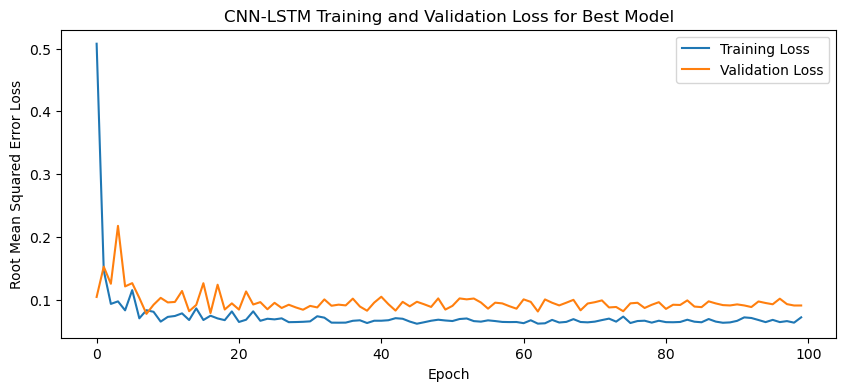

1/1 - 2s - loss: 0.0966 - 2s/epoch - 2s/step
Test Loss: 0.09663037955760956
Fold 4:
Epoch 1/100
20/20 [==============================] - 13s 119ms/step - loss: 0.6375 - val_loss: 0.0455
Epoch 2/100
20/20 [==============================] - 0s 9ms/step - loss: 0.1729 - val_loss: 0.2516
Epoch 3/100
20/20 [==============================] - 0s 12ms/step - loss: 0.1883 - val_loss: 0.2678
Epoch 4/100
20/20 [==============================] - 0s 10ms/step - loss: 0.1913 - val_loss: 0.0060
Epoch 5/100
20/20 [==============================] - 0s 9ms/step - loss: 0.1140 - val_loss: 0.2104
Epoch 6/100
20/20 [==============================] - 0s 9ms/step - loss: 0.1368 - val_loss: 0.1303
Epoch 7/100
20/20 [==============================] - 0s 9ms/step - loss: 0.1817 - val_loss: 0.2744
Epoch 8/100
20/20 [==============================] - 0s 7ms/step - loss: 0.1618 - val_loss: 0.0586
Epoch 9/100
20/20 [==============================] - 0s 7ms/step - loss: 0.1201 - val_loss: 0.0529
Epoch 10/100
20/20 [

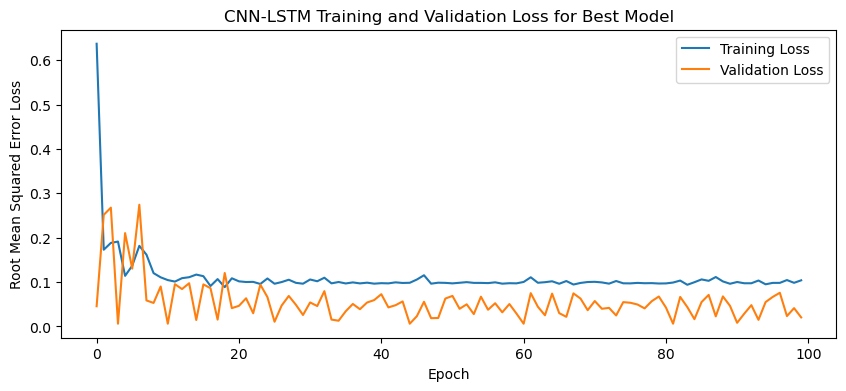

1/1 - 3s - loss: 0.1578 - 3s/epoch - 3s/step
Test Loss: 0.15780998766422272
Fold 5:
Epoch 1/100
19/19 [==============================] - 10s 119ms/step - loss: 0.4827 - val_loss: 0.2434
Epoch 2/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1872 - val_loss: 0.1723
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0886 - val_loss: 0.1257
Epoch 4/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0904 - val_loss: 0.0547
Epoch 5/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1196 - val_loss: 0.0642
Epoch 6/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1100 - val_loss: 0.0963
Epoch 7/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0929 - val_loss: 0.0588
Epoch 8/100
19/19 [==============================] - 0s 11ms/step - loss: 0.0904 - val_loss: 0.0682
Epoch 9/100
19/19 [==============================] - 0s 9ms/step - loss: 0.0914 - val_loss: 0.0644
Epoch 10/100
19/19 [=

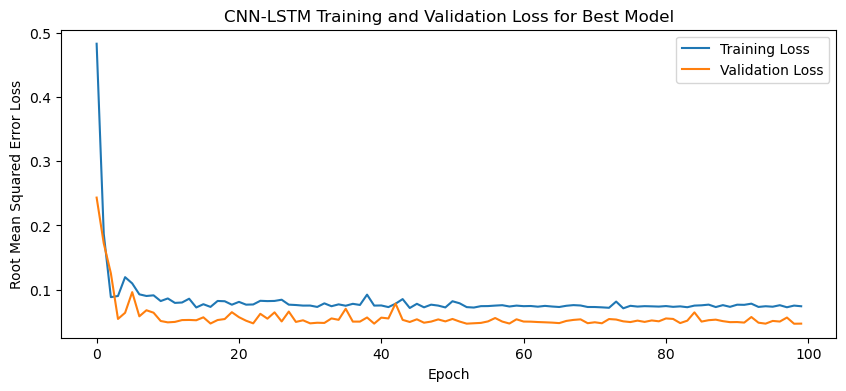

1/1 - 1s - loss: 0.0540 - 1s/epoch - 1s/step
Test Loss: 0.05401596054434776


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

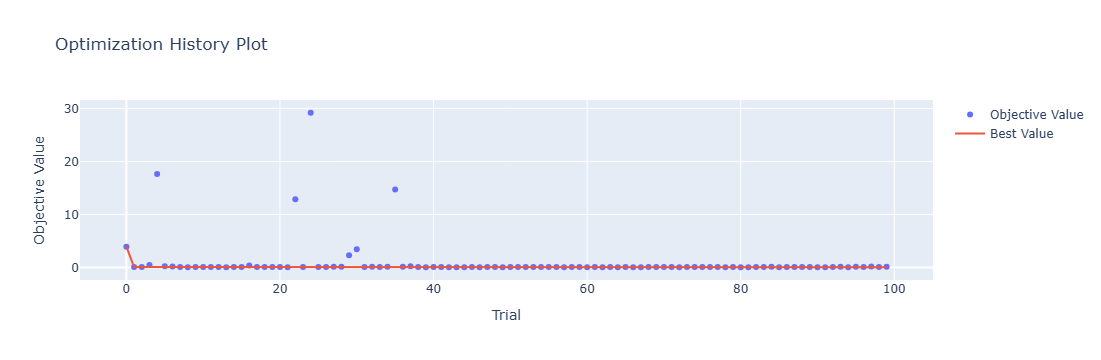

In [4]:
optuna.visualization.plot_optimization_history(study)

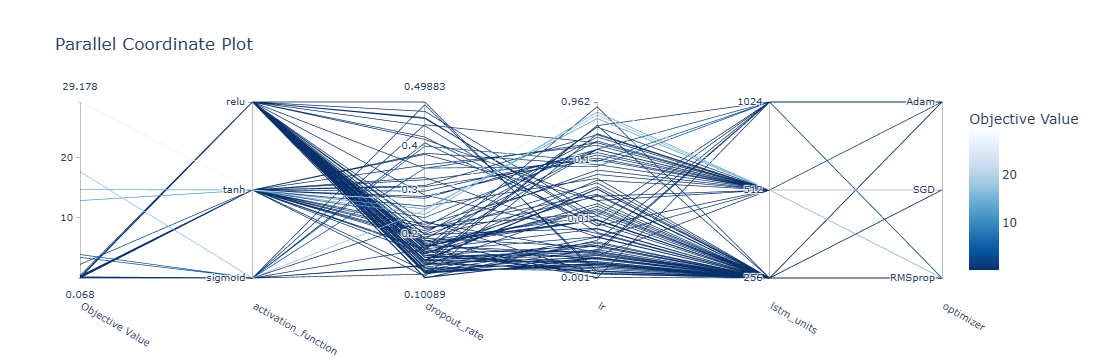

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

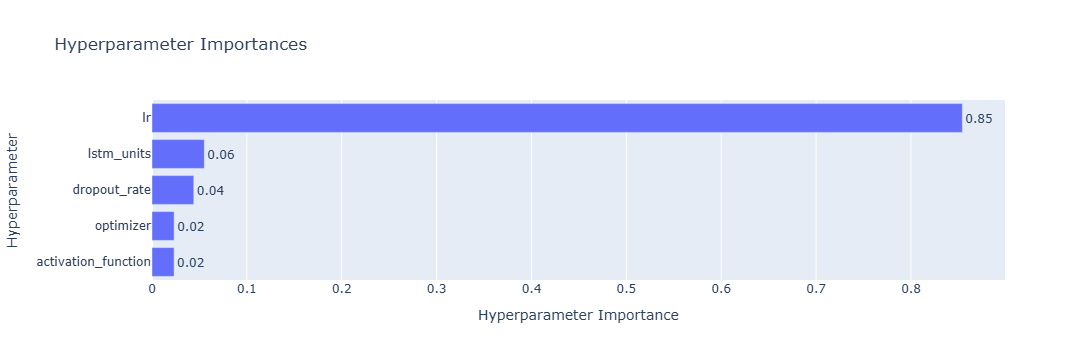

In [6]:
optuna.visualization.plot_param_importances(study)

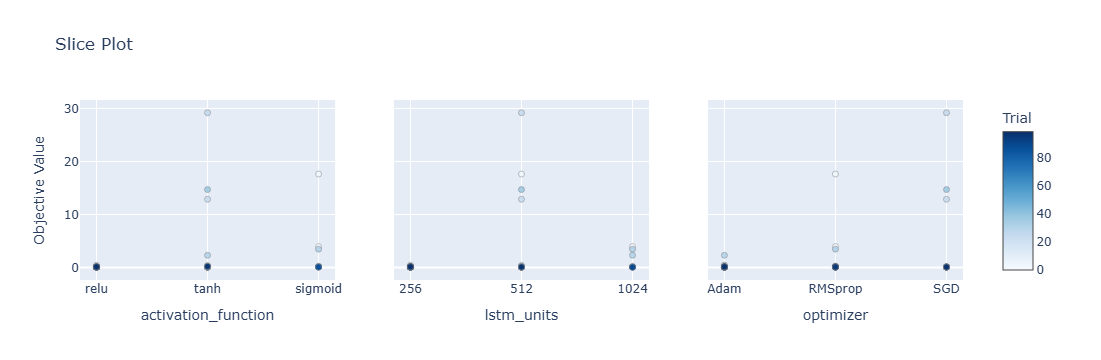

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

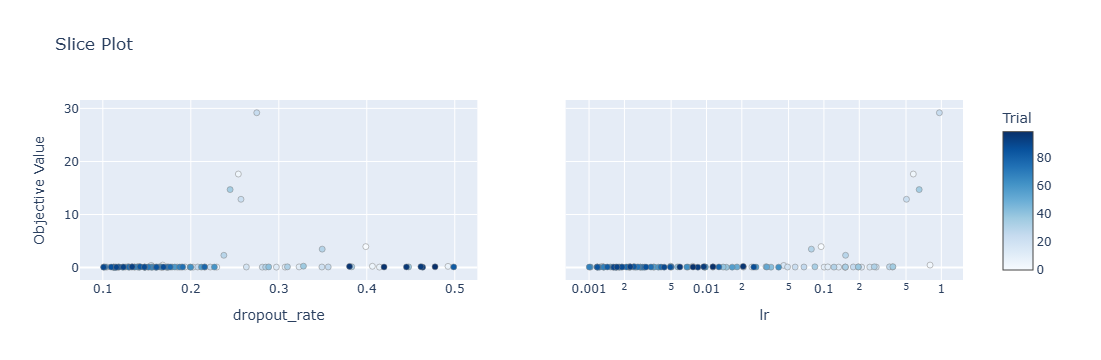

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[12.82 12.33 12.14 11.9  12.75 12.05 11.96 11.88 11.66 11.6  11.21 11.85
  11.29 12.12 12.23 11.95 11.91 12.96 13.05 13.43 12.59 12.54 12.66 12.47
  12.18 12.49 13.25]
 [10.07  9.17  8.73  9.1   9.64  9.62  9.38  9.31  8.9   8.65  8.67  9.09
   8.97  9.33  9.58  9.53  9.17 10.25  9.66 10.33 10.45 10.26 10.47 10.03
   9.51  9.7  10.33]]
Epoch 1/100
19/19 [==============================] - 22s 402ms/step - loss: 0.5431 - accuracy: 0.0000e+00 - mae: 0.5431 - rmse: 0.5431 - mape: 123.0485 - pearson: nan - val_loss: 0.0781 - val_accuracy: 0.0000e+00 - val_mae: 0.0781 - val_rmse: 0.0781 - val_mape: 17.4240 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 1s 54ms/step - loss: 0.1634 - accuracy: 0.0000e+00 - mae: 0.1634 - rmse: 0.1634 - mape: 35.0360 - pearson: nan - val_loss: 0.1300 - val_accuracy: 0.0000e+00 - val_mae: 0.1300 - val_rmse: 0.1300 - val_mape: 27.2809 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 1s 63ms/step - loss: 0.0898 - acc

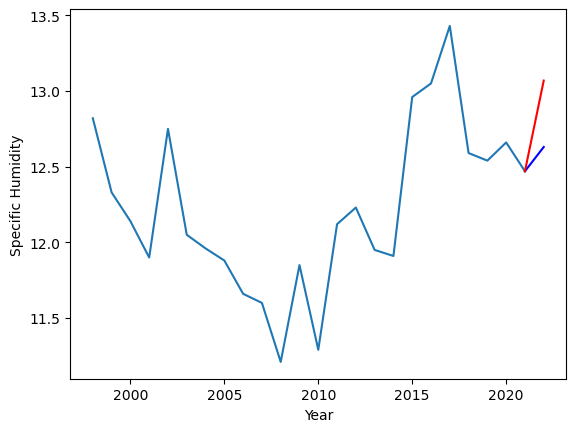

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
9.63		10.32		0.69


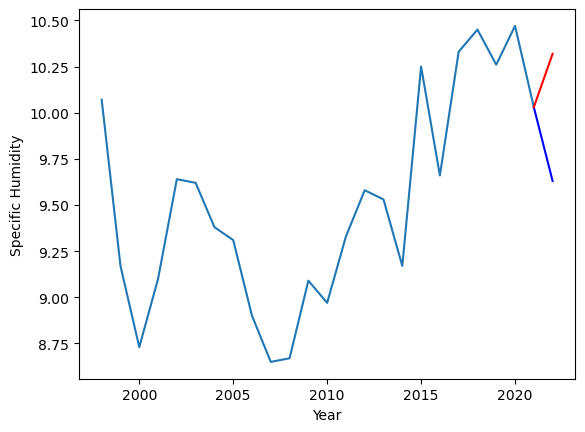

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   12.63  13.068758
1                1    9.63  10.318758


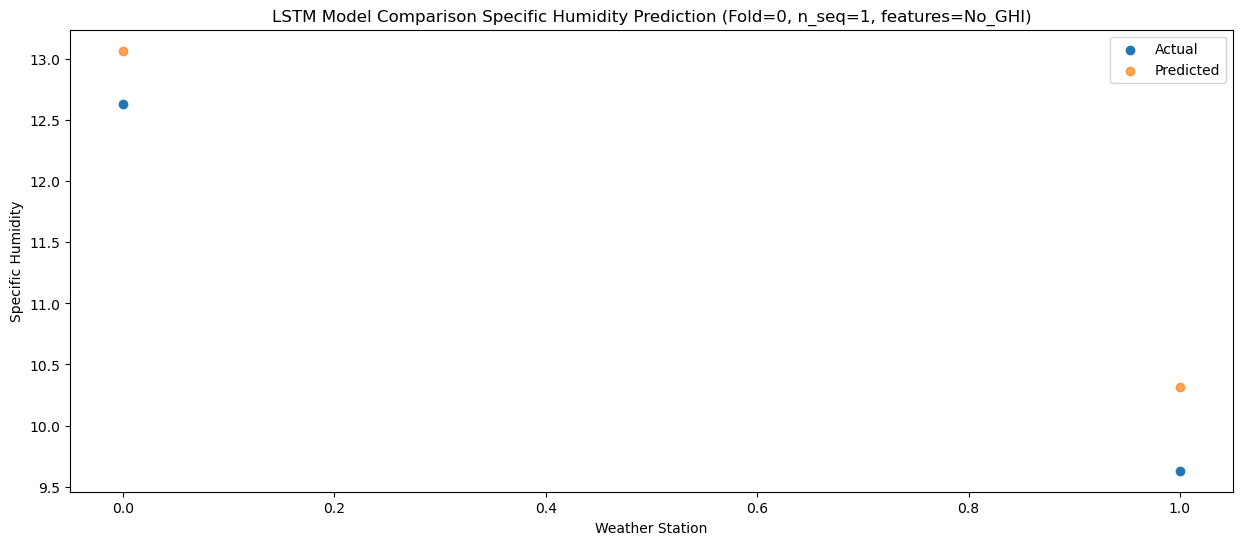

f, t:
[[12.63  9.63]]
[[13.06875762 10.31875762]]
Year at t+1:
t+1 SKRMSE: 0.577449
t+1 KRMSE: 0.577449
t+1 MAE: 0.563758
t+1 SKMAPE: 0.053131
t+1 R2_SCORE: 0.851801
t+1 KMAPE: 0.053131
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 11.130000
Metrics for this Fold:
SKRMSE: 0.577449
KRMSE: 0.577449
MAE: 0.563758
SKMAPE: 0.053131
R2_SCORE: 0.851801
KMAPE: 0.053131
PEARSON: 1.000000
AVERAGE ACTUAL: 11.130000
Model: "sequential_510"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1020 (LSTM)            (1, 1, 256)               510976    
                                                                 
 dropout_1020 (Dropout)      (1, 1, 256)               0         
                                                                 
 lstm_1021 (LSTM)            (1, 256)                  525312    
                                                                 
 dropout_1021 (Dropout)      (1, 256)       

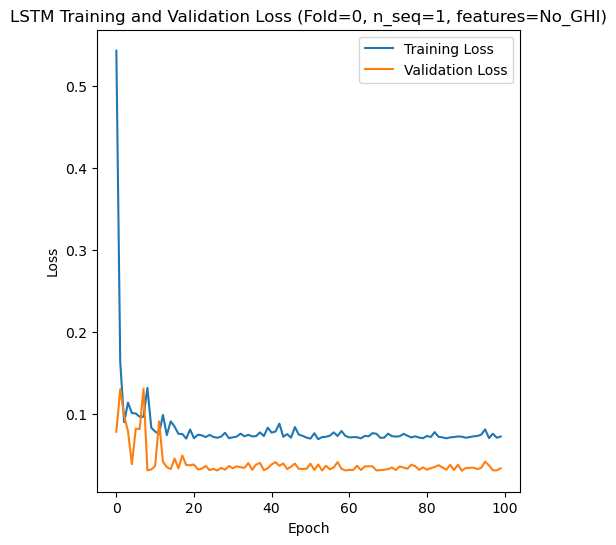

[[11.47 10.69 10.49 10.89 11.27 10.87 11.1  11.03 10.18 10.34 10.24 10.68
  10.6  10.94 10.76 10.47 10.42 11.26 10.81 11.26 11.81 11.14 11.5  10.83
  10.88 10.74 11.48]
 [ 7.63  7.36  7.16  7.53  7.72  7.87  8.49  7.73  6.89  8.03  6.62  6.93
   7.69  5.78  7.04  6.89  7.21  8.34  8.32  7.95  7.79  7.82  7.08  7.52
   6.95  7.1   7.65]]
Epoch 1/100
19/19 [==============================] - 21s 269ms/step - loss: 0.6006 - accuracy: 0.0000e+00 - mae: 0.6006 - rmse: 0.6006 - mape: 134.2834 - pearson: nan - val_loss: 0.1410 - val_accuracy: 0.0000e+00 - val_mae: 0.1410 - val_rmse: 0.1410 - val_mape: 26.8442 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 2s 101ms/step - loss: 0.1410 - accuracy: 0.0000e+00 - mae: 0.1410 - rmse: 0.1410 - mape: 30.1171 - pearson: nan - val_loss: 0.2597 - val_accuracy: 0.0000e+00 - val_mae: 0.2597 - val_rmse: 0.2597 - val_mape: 50.1944 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 2s 80ms/step - loss: 0.0965 - ac

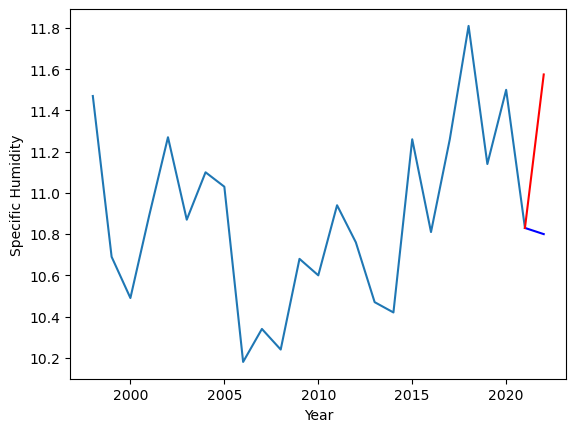

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.07		7.73		-0.34


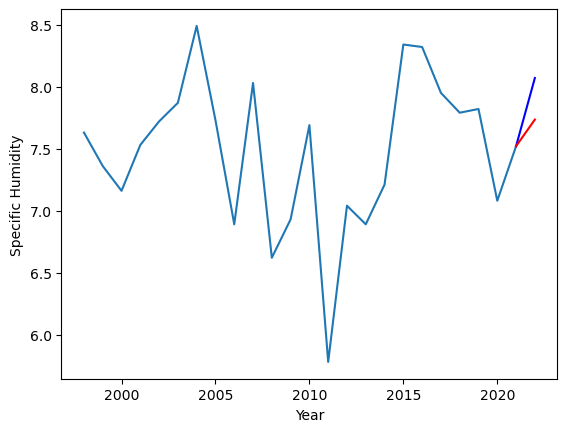

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   10.80  11.574563
1                1    8.07   7.734563


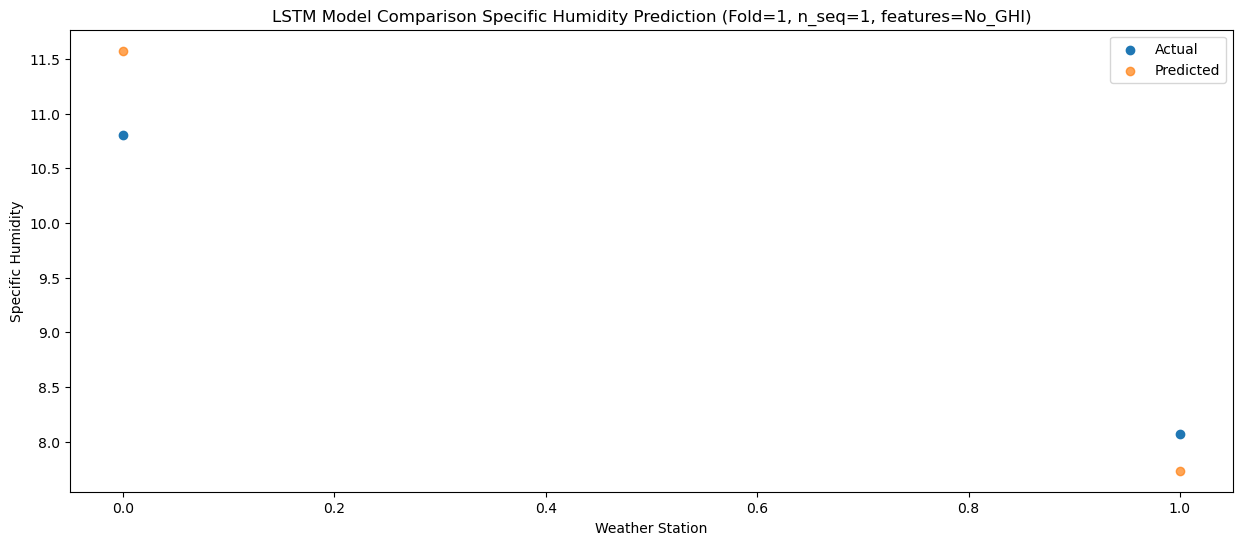

f, t:
[[10.8   8.07]]
[[11.57456268  7.73456268]]
Year at t+1:
t+1 SKRMSE: 0.596852
t+1 KRMSE: 0.596852
t+1 MAE: 0.555000
t+1 SKMAPE: 0.056642
t+1 R2_SCORE: 0.808809
t+1 KMAPE: 0.056642
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.435000
Metrics for this Fold:
SKRMSE: 0.596852
KRMSE: 0.596852
MAE: 0.555000
SKMAPE: 0.056642
R2_SCORE: 0.808809
KMAPE: 0.056642
PEARSON: 1.000000
AVERAGE ACTUAL: 9.435000
Model: "sequential_511"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1022 (LSTM)            (1, 1, 256)               510976    
                                                                 
 dropout_1022 (Dropout)      (1, 1, 256)               0         
                                                                 
 lstm_1023 (LSTM)            (1, 256)                  525312    
                                                                 
 dropout_1023 (Dropout)      (1, 256)         

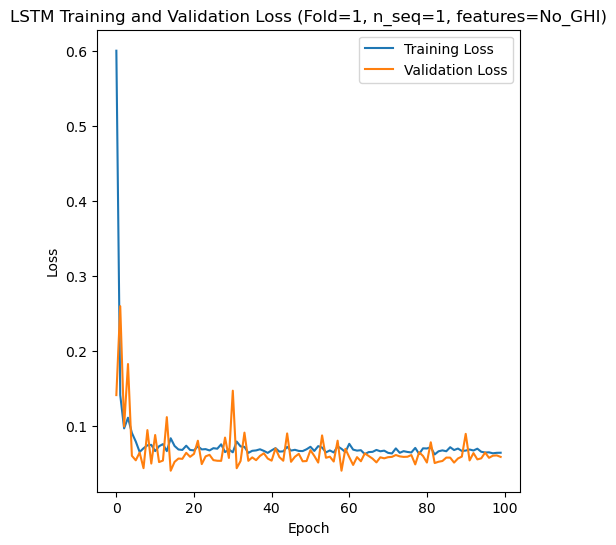

[[ 9.91  9.14  8.93  8.85  8.98  9.08  8.94  8.84  8.35  8.13  8.01  8.88
   8.79  8.86  9.22  8.7   8.51  9.48  9.05  9.73 10.13  9.86  9.33  8.92
   8.82  9.09  9.65]
 [ 8.49  7.33  7.71  7.76  7.77  7.75  7.45  7.41  7.43  7.25  7.05  7.35
   7.52  7.92  7.47  7.81  7.    7.75  8.3   8.25  8.35  7.7   7.52  7.59
   7.86  7.87  8.55]]
Epoch 1/100
19/19 [==============================] - 31s 361ms/step - loss: 0.5939 - accuracy: 0.0000e+00 - mae: 0.5939 - rmse: 0.5939 - mape: 118.8052 - pearson: nan - val_loss: 0.1824 - val_accuracy: 0.0000e+00 - val_mae: 0.1824 - val_rmse: 0.1824 - val_mape: 31.7123 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 1s 32ms/step - loss: 0.1316 - accuracy: 0.0000e+00 - mae: 0.1316 - rmse: 0.1316 - mape: 31.8478 - pearson: nan - val_loss: 0.1299 - val_accuracy: 0.0000e+00 - val_mae: 0.1299 - val_rmse: 0.1299 - val_mape: 21.8029 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 1s 33ms/step - loss: 0.1423 - acc

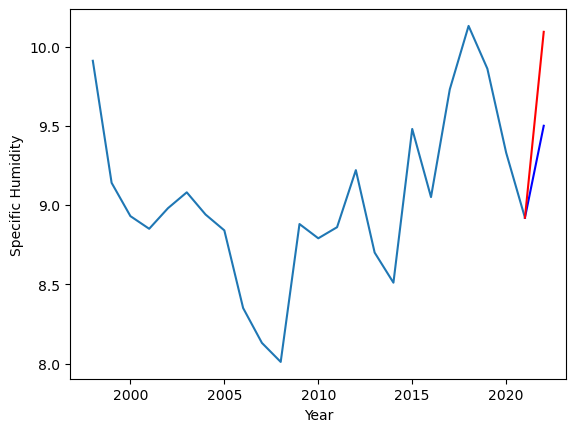

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.56		8.67		0.11


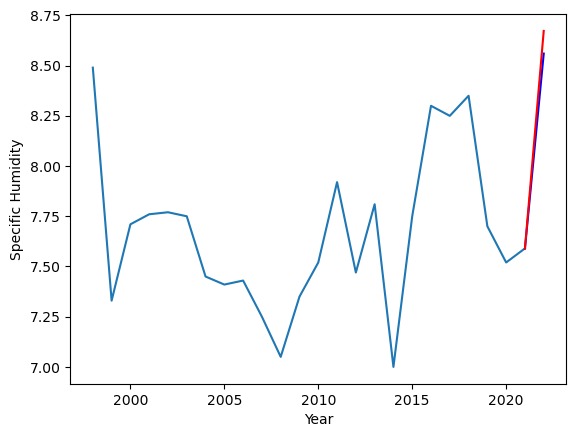

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    9.50   10.09278
1                1    8.56    8.67278


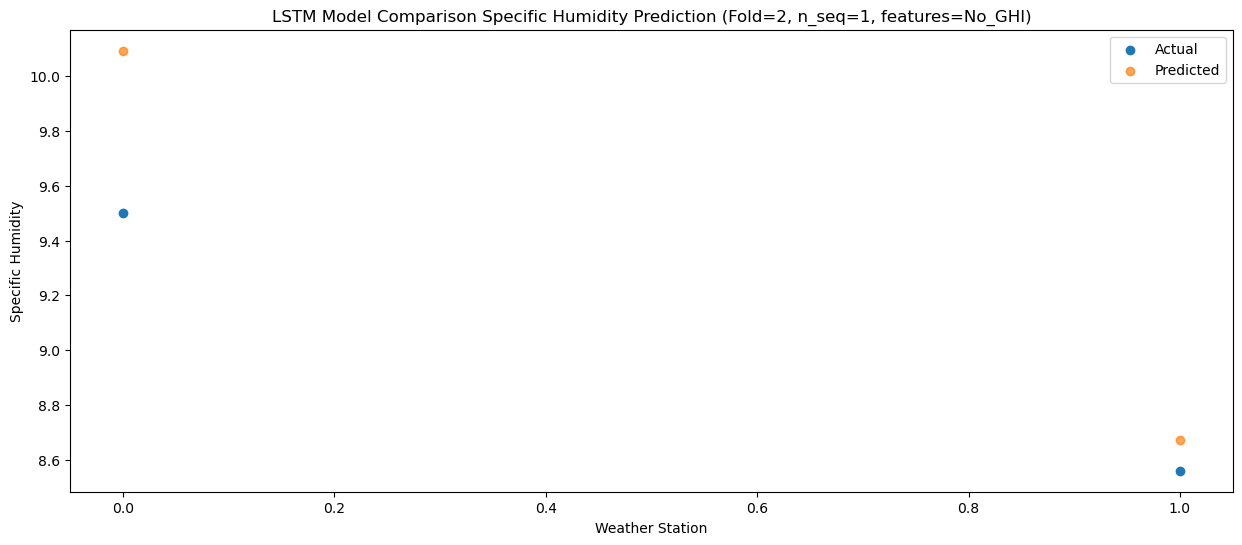

f, t:
[[9.5  8.56]]
[[10.09278046  8.67278046]]
Year at t+1:
t+1 SKRMSE: 0.426678
t+1 KRMSE: 0.426678
t+1 MAE: 0.352780
t+1 SKMAPE: 0.037787
t+1 R2_SCORE: 0.175853
t+1 KMAPE: 0.037787
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.030000
Metrics for this Fold:
SKRMSE: 0.426678
KRMSE: 0.426678
MAE: 0.352780
SKMAPE: 0.037787
R2_SCORE: 0.175853
KMAPE: 0.037787
PEARSON: 1.000000
AVERAGE ACTUAL: 9.030000
Model: "sequential_512"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1024 (LSTM)            (1, 1, 256)               510976    
                                                                 
 dropout_1024 (Dropout)      (1, 1, 256)               0         
                                                                 
 lstm_1025 (LSTM)            (1, 256)                  525312    
                                                                 
 dropout_1025 (Dropout)      (1, 256)           

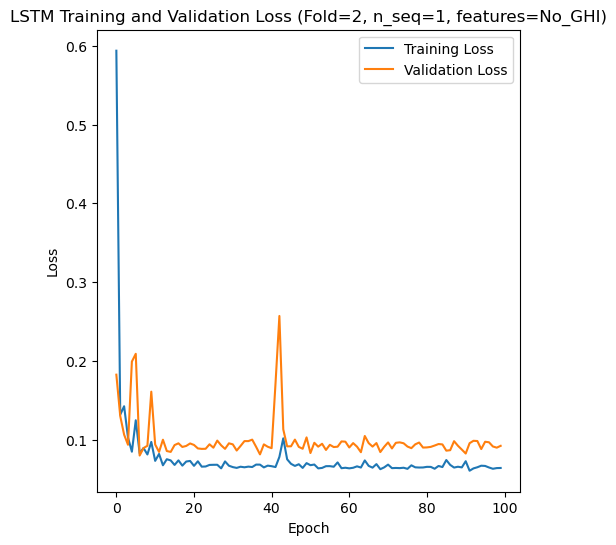

[[4.45 7.03 7.66 7.5  7.   7.5  6.8  7.19 6.85 6.32 6.46 6.61 7.06 6.53
  6.68 6.3  6.77 6.95 6.79 7.44 7.02 7.12 7.47 7.01 6.62 7.19 7.31]
 [8.33 7.39 7.85 8.23 8.15 7.91 8.01 7.7  7.52 7.54 7.12 7.57 7.71 8.23
  7.93 7.83 7.45 8.09 8.19 8.01 8.37 8.25 8.16 8.13 7.66 7.68 8.3 ]]
Epoch 1/100
20/20 [==============================] - 27s 403ms/step - loss: 0.5350 - accuracy: 0.0000e+00 - mae: 0.5350 - rmse: 0.5350 - mape: 88.8892 - pearson: nan - val_loss: 0.0247 - val_accuracy: 0.0000e+00 - val_mae: 0.0247 - val_rmse: 0.0247 - val_mape: 3.5365 - val_pearson: nan
Epoch 2/100
20/20 [==============================] - 1s 54ms/step - loss: 0.1663 - accuracy: 0.0000e+00 - mae: 0.1663 - rmse: 0.1663 - mape: 28.5711 - pearson: nan - val_loss: 0.1155 - val_accuracy: 0.0000e+00 - val_mae: 0.1155 - val_rmse: 0.1155 - val_mape: 16.5879 - val_pearson: nan
Epoch 3/100
20/20 [==============================] - 1s 54ms/step - loss: 0.1118 - accuracy: 0.0000e+00 - mae: 0.1118 - rmse: 0.1118 - mape: 17.03

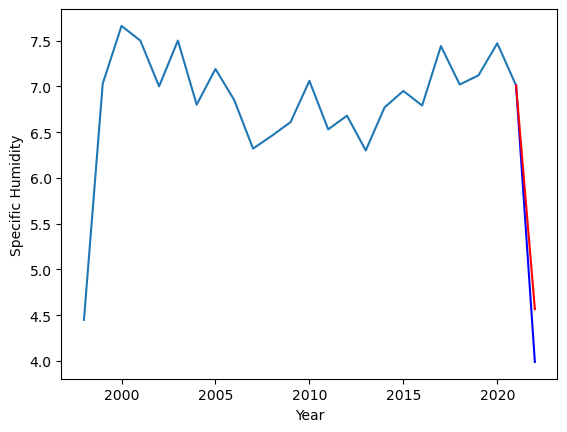

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.30		8.45		0.15


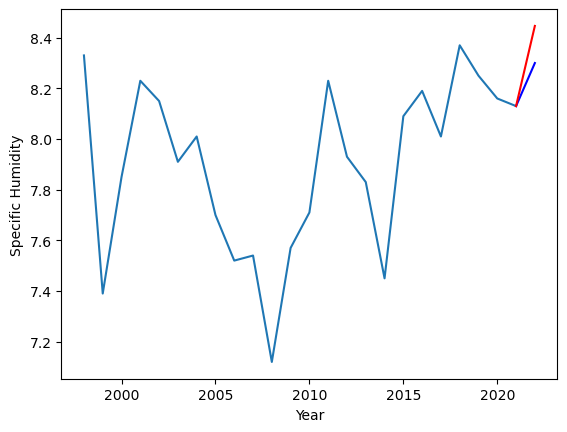

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    3.99   4.566492
1                1    8.30   8.446493


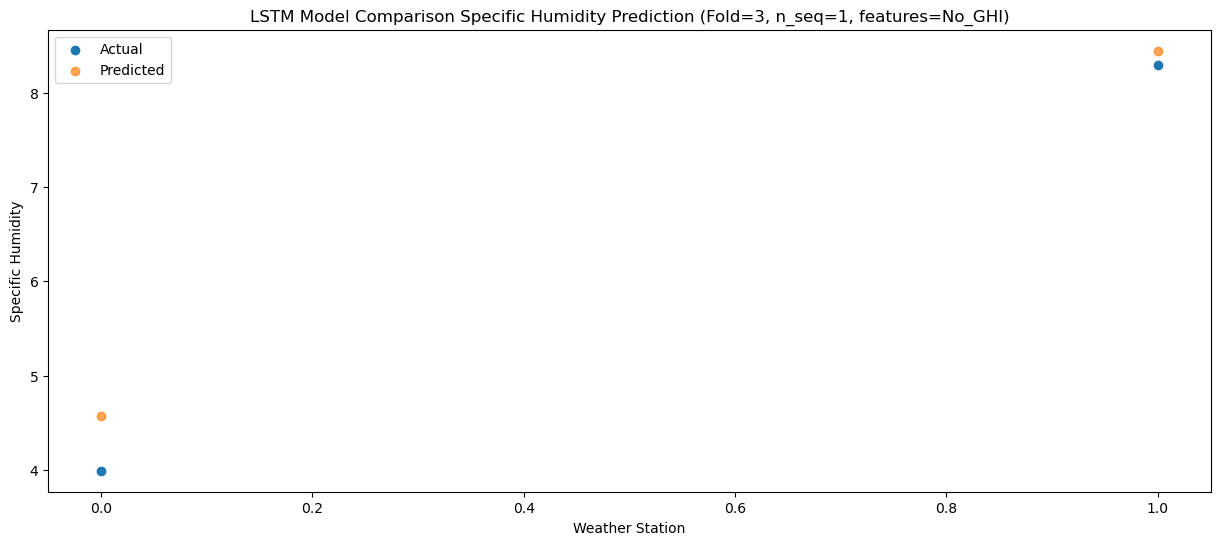

f, t:
[[3.99 8.3 ]]
[[4.56649248 8.44649267]]
Year at t+1:
t+1 SKRMSE: 0.420597
t+1 KRMSE: 0.420597
t+1 MAE: 0.361493
t+1 SKMAPE: 0.081067
t+1 R2_SCORE: 0.961908
t+1 KMAPE: 0.081067
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 6.145000
Metrics for this Fold:
SKRMSE: 0.420597
KRMSE: 0.420597
MAE: 0.361493
SKMAPE: 0.081067
R2_SCORE: 0.961908
KMAPE: 0.081067
PEARSON: 1.000000
AVERAGE ACTUAL: 6.145000
Model: "sequential_513"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1026 (LSTM)            (1, 1, 256)               510976    
                                                                 
 dropout_1026 (Dropout)      (1, 1, 256)               0         
                                                                 
 lstm_1027 (LSTM)            (1, 256)                  525312    
                                                                 
 dropout_1027 (Dropout)      (1, 256)             

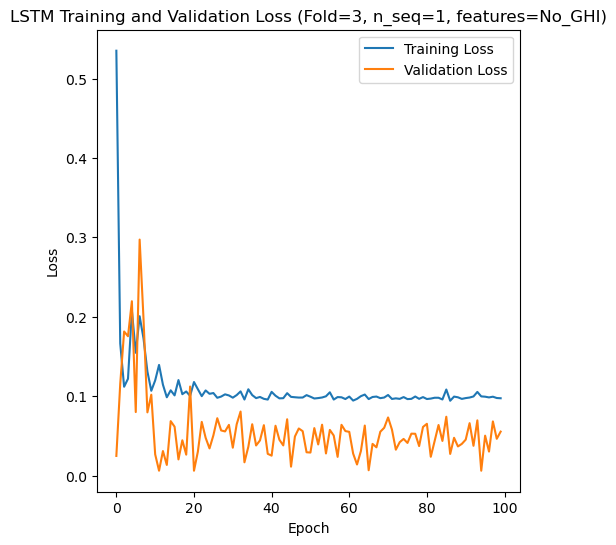

[[11.16  9.55  9.55 10.04  9.82  9.68 10.08  8.81  8.71 10.02  8.91  9.32
   9.71  8.86  9.35  8.98  8.99  9.85 10.25 10.41  9.69  9.69  9.59  9.94
   9.15  9.7  10.89]
 [ 8.33  7.32  7.52  7.52  7.95  7.22  7.21  7.13  7.15  7.14  7.22  7.24
   7.84  7.63  7.34  7.44  7.18  7.84  8.31  7.98  8.38  7.84  7.57  7.9
   7.3   7.53  8.43]]
Epoch 1/100
19/19 [==============================] - 23s 472ms/step - loss: 0.5503 - accuracy: 0.0000e+00 - mae: 0.5503 - rmse: 0.5503 - mape: 125.2953 - pearson: nan - val_loss: 0.0510 - val_accuracy: 0.0000e+00 - val_mae: 0.0510 - val_rmse: 0.0510 - val_mape: 13.9186 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 1s 52ms/step - loss: 0.1342 - accuracy: 0.0000e+00 - mae: 0.1342 - rmse: 0.1342 - mape: 29.8101 - pearson: nan - val_loss: 0.0504 - val_accuracy: 0.0000e+00 - val_mae: 0.0504 - val_rmse: 0.0504 - val_mape: 13.7294 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 1s 46ms/step - loss: 0.1312 - accu

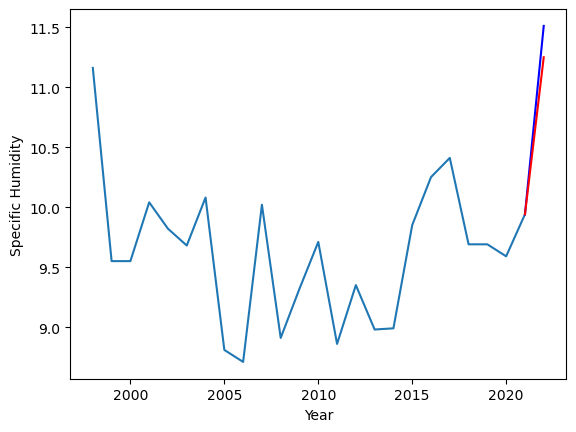

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.66		8.42		-0.24


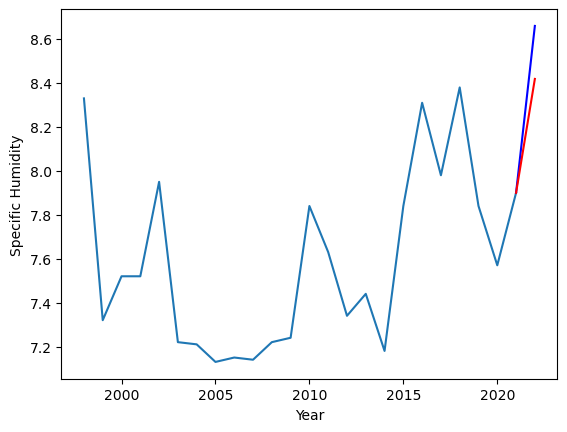

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   11.51  11.248642
1                1    8.66   8.418642


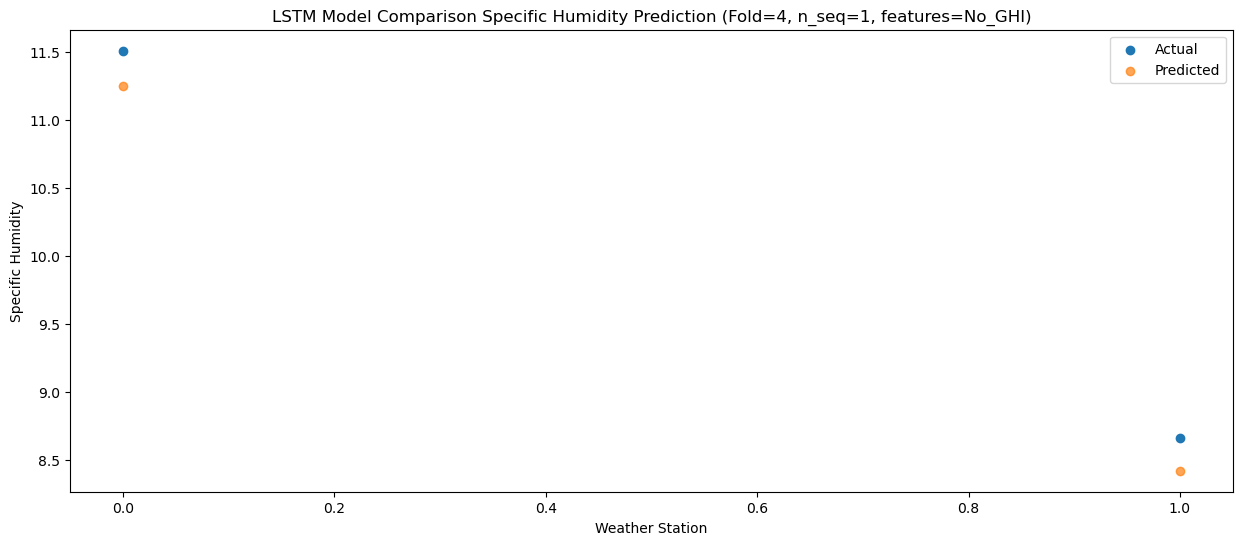

f, t:
[[11.51  8.66]]
[[11.24864152  8.41864152]]
Year at t+1:
t+1 SKRMSE: 0.251557
t+1 KRMSE: 0.251557
t+1 MAE: 0.251358
t+1 SKMAPE: 0.025289
t+1 R2_SCORE: 0.968837
t+1 KMAPE: 0.025289
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 10.085000
Metrics for this Fold:
SKRMSE: 0.251557
KRMSE: 0.251557
MAE: 0.251358
SKMAPE: 0.025289
R2_SCORE: 0.968837
KMAPE: 0.025289
PEARSON: 1.000000
AVERAGE ACTUAL: 10.085000
Model: "sequential_514"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1028 (LSTM)            (1, 1, 256)               510976    
                                                                 
 dropout_1028 (Dropout)      (1, 1, 256)               0         
                                                                 
 lstm_1029 (LSTM)            (1, 256)                  525312    
                                                                 
 dropout_1029 (Dropout)      (1, 256)       

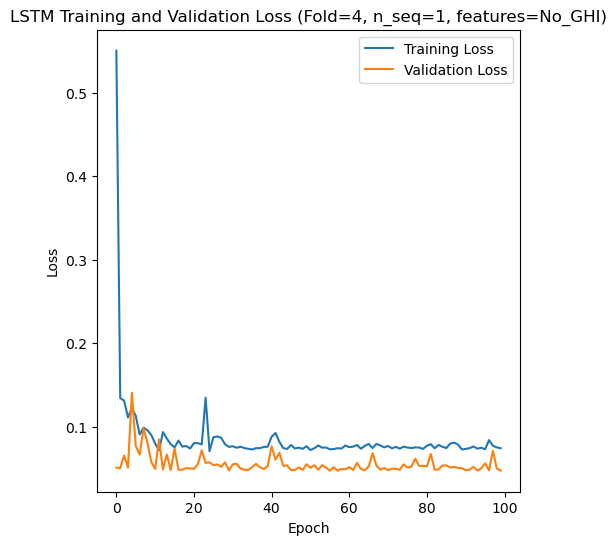

[[0.577449261185222], [0.5968523876116186], [0.4266779261004732], [0.4205970060556798], [0.25155731613043336]]
[[array(0.57744926)], [array(0.59685239)], [array(0.42667793)], [array(0.42059701)], [array(0.25155732)]]
[[0.5637576156854633], [0.5550000000000002], [0.3527804595232009], [0.361492576897144], [0.2513584756851195]]
[[0.05313069939774186], [0.05664236466933116], [0.03778661521759105], [0.08106702528323625], [0.025288786207439164]]
[[0.8518010447807296], [0.8088085053615695], [0.1758530890837433], [0.9619076465990167], [0.9688366471905218]]
[[array(0.0531307)], [array(0.05664236)], [array(0.03778662)], [array(0.08106703)], [array(0.02528879)]]
[[array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)]]
[12.63  9.63 10.8   8.07  9.5   8.56  3.99  8.3  11.51  8.66]
[13.06875762 10.31875762 11.57456268  7.73456268 10.09278046  8.67278046
  4.56649248  8.44649267 11.24864152  8.41864152]
Accuracy Results:
RMSE for each fold:
[[0.577449261185222], [0.5968523876116186], [0.4266

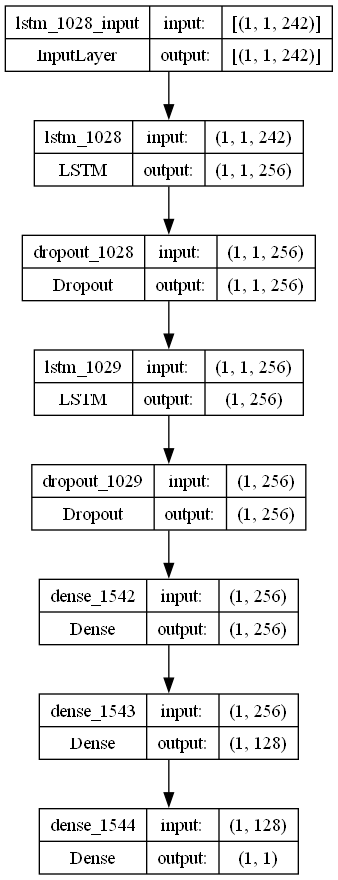

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    lr = 0.014778545662628663
    optimizer = Adam(learning_rate = lr)
    activation_function = 'relu'
    lstm_units = 256
    dropout_rate = 0.17291248840804552

    # design network
    model = Sequential()
    #model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# make one forecast with an LSTM,
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []
    actual_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        avg_actual = np.mean(act)
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))
        print('t+%d AVERAGE ACTUAL: %f' % ((i+1), avg_actual))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    avg_actual = np.mean(np.array(y_true))
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    actual_list.append(avg_actual)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))
    print('AVERAGE ACTUAL: %f' % (avg_actual))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
actual_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (specific_humidity)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Specific Humidity')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction
    actual_list = [] # list stores average actual values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)
    actual_avg_list.append(actual_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))
print("")
print("Average Specific Humidity:"+str(np.mean(actual_avg_list)))
print("RMSE % of Specific Humidity:"+str(np.mean(rmse2_avg_list)/np.mean(actual_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_SH_S1_No_GHI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)